will later move this into function script

In [1]:
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
from IPython.display import display


In [2]:
possible_files = ["controlled", "scenarios", "grid", "text_generation"]

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

def process_possible_files(func, *args, **kwargs):
    """
    Loops over the global list 'possible_files', calls the provided function on each file,
    and creates a global variable with the naming convention 'df_<file>_cleaned'
    to store the resulting DataFrame.
    
    Parameters:
        func (callable): A function that takes at least a file name (first argument).
        *args: Additional positional arguments that 'func' needs.
        **kwargs: Additional keyword arguments that 'func' needs.
    
    The function will also attempt to display each transposed DataFrame.
    """
    for file in possible_files:
        try:
            var_name = f"df_{file}_cleaned"
            # Run the provided function on the file, passing along any additional arguments.
            result_df = func(file, *args, **kwargs)
            # Dynamically create a global variable with the result.
            globals()[var_name] = result_df
            print(f"Found & inspecting: {var_name}")
            display(result_df.T)
        except Exception as e:
            print(f"{file} did not process correctly: {e}")

In [6]:
notebook_dir = os.getcwd()
df = process_possible_files
df = pd.read_csv("controlled_results.csv")

columns = list(df.columns)
for col in columns:
    print(col)

global_energy_metrics_local_process_results_cpu_power_process_2
global_energy_metrics_global_experiment_results_gpu_energy_total
compute_metrics_compute_utilisation_cpu_usage_percent
global_energy_metrics_per-process_emissions_1
variables_backend
global_energy_metrics_local_process_results_gpu_energy_process_0
compute_metrics_compute_utilisation_gpu_utilization_percent_3
variables_sharding_config_fsdp_config_cpu_offload
model_architecture_total_params
variables_config_name
global_energy_metrics_local_process_results_ram_energy_process_3
inference_metrics_raw_inference_metrics_total_generated_tokens
setup_os
setup_available_gpu_count
global_energy_metrics_global_experiment_results_cpu_power_avg
global_energy_metrics_local_process_results_total_energy_joules_process_2
global_energy_metrics_experiment_id
compute_metrics_compute_utilisation_gpu_utilization_percent_2
compute_metrics_compute_utilisation_gpu_utilization_percent_0
variables_number_input_prompts
inference_metrics_raw_inference_

In [7]:
def clean_column(col: str) -> str:
    """
    Clean a single column name by:
      - Stripping whitespace and replacing any non-standard quotes.
      - Checking for per-process metric patterns.
      - Applying special renames.
      - Removing the 'variables_' prefix if present.
      - Otherwise, attempting to strip off any messy prefixes using a known list of tokens.
    
    If no known token is found, the original (normalized) column name is returned.
    """
    # Normalize the column string: remove extra whitespace and fix common issues with quotes.
    col = col.strip()
    col = col.replace("“", "\"").replace("”", "\"")
    
    # 1. Special exact mappings.
    special_mappings = {
        "setup_cpu_model": "cpu_model",
        "setup_gpu_model": "gpu_model",
        "model_architecture_total_params": "total_params",  # now maps to total_params
        "model_architecture_architecture": "model_arch"
    }
    if col in special_mappings:
        return special_mappings[col]
    
    # 2. Remove the 'variables_' prefix if it exists.
    if col.startswith("variables_"):
        col = col[len("variables_"):]
    
    # 3. First, check if it is a per-process metric column.
    per_process_patterns = [
        r'(cpu_power_process_\d+)',
        r'(gpu_power_process_\d+)',
        r'(ram_power_process_\d+)',
        r'(cpu_energy_process_\d+)',
        r'(gpu_energy_process_\d+)',
        r'(ram_energy_process_\d+)',
        r'(total_energy_kwh_process_\d+)',
        r'(total_energy_joules_process_\d+)'
    ]
    for pattern in per_process_patterns:
        match = re.search(pattern, col)
        if match:
            return match.group(1)
    
    # 4. For non-per-process columns, search for a known token in the cleaned column.
    tokens = [
        "config_name", "experiment_id", "date_time", "model", "is_encoder_decoder",
        "task_type", "available_gpu_count", "gpu_model", "available_cpu_count", "cpu_model",
        "os", "python_version", "country", "region", "fsdp_use_orig_params", "fsdp_cpu_offload",
        "sharding_strategy", "distributed_type", "num_processes", "max_input_tokens", "max_output_tokens",
        "number_input_prompts", "decode_token_to_text", "decoder_temperature", "decoder_top_k", "decoder_top_p",
        "query_rate", "latency_simulate", "latency_delay_min", "latency_delay_max", "latency_simulate_burst",
        "latency_burst_interval", "latency_burst_size", "fp_precision", "quantization", "load_in_8bit",
        "load_in_4bit", "cached_flops_for_quantised_models", "batch_size___fixed_batching", "adaptive_batching",
        "adaptive_max_tokens", "max_batch_size___adaptive_batching", "inference_type", "backend", "total_params",
        "architecture", "total_input_tokens", "total_generated_tokens", "total_inference_time_sec", 
        "average_latency_ms_per_batch", "throughput_queries_per_sec", "throughput_tokens_per_sec", "flops",
        "gpu_current_memory_allocated_bytes", "gpu_max_memory_allocated_bytes", "gpu_current_memory_reserved_bytes",
        "gpu_max_memory_reserved_bytes", "gpu_utilization_percent", "cpu_usage_percent", "cpu_memory_usage_bytes",
        # Per-process metrics:
        "cpu_power_process_0", "gpu_power_process_0", "ram_power_process_0",
        "cpu_energy_process_0", "gpu_energy_process_0", "ram_energy_process_0",
        "total_energy_kwh_process_0", "total_energy_joules_process_0",
        # Global averages and totals:
        "cpu_power_avg", "gpu_power_avg", "ram_power_avg", "cpu_energy_total", "gpu_energy_total", "ram_energy_total",
        "total_energy_kwh", "total_energy_joules", "tokens_per_joule", "joules_per_token", "flops_per_joule", "joules_per_flop",
        "per-process_emissions"
    ]
    
    for token in tokens:
        if token in col:
            idx = col.find(token)
            return col[idx:]
    
    return col

def resolve_duplicates(df: pd.DataFrame) -> pd.DataFrame:
    """
    Resolve duplicate columns in the DataFrame.
    
    For any column that appears more than once:
      - For 'adaptive_batching', if duplicates exist, prefer the one with a boolean dtype;
        otherwise, pick the first occurrence.
      - For all other columns (including 'experiment_id' and 'number_input_prompts'),
        keep only the first occurrence.
    """
    # Build a mapping of column name to list of indices where it occurs.
    seen = {}
    for idx, col in enumerate(df.columns):
        seen.setdefault(col, []).append(idx)
    
    # Choose one index per duplicate group.
    chosen_indices = []
    for col, indices in seen.items():
        if len(indices) == 1:
            chosen_indices.append(indices[0])
        else:
            if col == "adaptive_batching":
                # Look for a column with boolean type.
                bool_idx = None
                for i in indices:
                    if pd.api.types.is_bool_dtype(df.iloc[:, i]):
                        bool_idx = i
                        break
                chosen_indices.append(bool_idx if bool_idx is not None else indices[0])
            else:
                # For experiment_id, number_input_prompts, or any duplicate, keep the first occurrence.
                chosen_indices.append(indices[0])
    
    # Sort indices to preserve the original order.
    chosen_indices.sort()
    return df.iloc[:, chosen_indices]

def clean_and_reorder_columns(df: pd.DataFrame, desired_order: list) -> pd.DataFrame:
    """
    Clean DataFrame columns by:
      1. Renaming each column to remove extraneous prefixes and apply special mappings.
      2. Removing duplicates (applying special resolution for some columns).
      3. Reordering columns into the order specified by 'desired_order'. Any columns not explicitly mentioned
         will be appended at the end.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame with messy, flattened column names.
        desired_order (list): List of column names (after cleaning) indicating the preferred ordering.
        
    Returns:
        pd.DataFrame: DataFrame with cleaned and reordered columns.
    """
    # Build mapping from original column names to cleaned names.
    mapping = {col: clean_column(col) for col in df.columns}
    
    # Rename columns in the DataFrame.
    df = df.rename(columns=mapping)
    
    # Resolve duplicates as required.
    df = resolve_duplicates(df)
    
    # Reorder columns: first, the ones matching the desired order.
    ordered_cols = [col for col in desired_order if col in df.columns]
    # Then, append any remaining columns.
    remaining_cols = [col for col in df.columns if col not in desired_order]
    final_order = ordered_cols + remaining_cols
    
    return df[final_order]

# Example desired order list
desired_order = [
    "config_name",
    "experiment_id",
    "date_time",
    "model",
    # num_process
    "num_processes",
    # batching
    "batch_size___fixed_batching",
    # decodeer
    "decoder_temperature",
    "decoder_top_k",
    "decoder_top_p",
    # latency
    "latency_simulation_simulate"
    "latency_simulation_delay_max",
    "latency_simulation_delay_min",
    "latency_simulation_simulate_burst",
    "latency_simulation_burst_size",
    "latency_simulation_burst_interval",
    # precision / quantisation
    "fp_precision",
    "quantization",
    "load_in_8bit",
    "load_in_4bit",
    "cached_flops_for_quantised_models",
    
    # UNUSED PARAMS
    "sharding_strategy",
    "sharding_config_fsdp_config_use_orig_params",
    "sharding_config_fsdp_config_cpu_offload",
    "adaptive_batching",
    "adaptive_max_tokens",
    "query_rate",
    "total_input_tokens",
    "total_generated_tokens"
    
    # CONSTANT SETUP ====
    "date_time",
    "is_encoder_decoder",
    "task_type",
    "available_gpu_count",
    "gpu_model",
    "available_cpu_count",
    "cpu_model",
    "os",
    "python_version",
    "country",
    "region",
    "distributed_type",
    "decode_token_to_text",
    "inference_type",
    "backend",
    "total_params",
    "model_arch",

    # Validation (should be same):
    "max_input_tokens",
    "max_output_tokens",
    "number_input_prompts",
    
    # RESULTS =====
    # energy
    "total_energy_kwh",
    "total_energy_joules",
    # FLOPS
    "flops",
    "tokens_per_joule",
    "joules_per_token",
    "flops_per_joule",
    "joules_per_flop",
    "total_inference_time_sec", 
    # inference performance
    "average_latency_ms_per_batch",
    "throughput_queries_per_sec",
    "throughput_tokens_per_sec",
    # CPU utilization
    "cpu_usage_percent",
    "cpu_memory_usage_bytes",
    # GPU utilization
    "gpu_utilization_percent_0", "gpu_utilization_percent_1", "gpu_utilization_percent_2", "gpu_utilization_percent_3",
    # Compute mem
    "gpu_current_memory_allocated_bytes",
    "gpu_max_memory_allocated_bytes",
    "gpu_current_memory_reserved_bytes",
    "gpu_max_memory_reserved_bytes",
    # Per-process metrics:
    "cpu_power_process_0", "cpu_power_process_1", "cpu_power_process_2", "cpu_power_process_3",
    "gpu_power_process_0", "gpu_power_process_1", "gpu_power_process_2", "gpu_power_process_3",
    "ram_power_process_0", "ram_power_process_1", "ram_power_process_2", "ram_power_process_3",
    "cpu_energy_process_0", "cpu_energy_process_1", "cpu_energy_process_2", "cpu_energy_process_3",
    "gpu_energy_process_0", "gpu_energy_process_1", "gpu_energy_process_2", "gpu_energy_process_3",
    "ram_energy_process_0", "ram_energy_process_1", "ram_energy_process_2", "ram_energy_process_3",
    "total_energy_kwh_process_0", "total_energy_kwh_process_1", "total_energy_kwh_process_2", "total_energy_kwh_process_3",
    "total_energy_joules_process_0", "total_energy_joules_process_1", "total_energy_joules_process_2", "total_energy_joules_process_3",
    # Global averages and totals:
    "cpu_power_avg",
    "gpu_power_avg",
    "ram_power_avg",
    "cpu_energy_total",
    "gpu_energy_total",
    "ram_energy_total",
    # per-process_emsisisons
    "per-process_emissions_0", "per-process_emissions_1", "per-process_emissions_2","per-process_emissions_3"
]

def inspect_results(name, desired_order):
    input_file = f"{name}_results.csv"
    
    df = pd.read_csv(input_file)
    df_cleaned = clean_and_reorder_columns(df, desired_order)
    
    return df_cleaned


# COME BACK TO THIS
#process_possible_files(func=clean_and_reorder_columns, 
#                       desired_order=desired_order)


In [8]:
def inspect_results(name, desired_order):
    input_file = f"{name}_results.csv"
    
    df = pd.read_csv(input_file)
    df_cleaned = clean_and_reorder_columns(df, desired_order)
    
    return df_cleaned

possible_files = ["controlled", "scenarios", "grid", "text_generation"]

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

for file in possible_files:
    try:
        var_name = f"df_{file}_cleaned"
        globals()[var_name] = inspect_results(file, desired_order)  # dynamically create variable
        print(f"Found & inspecting: {var_name}")
        display(globals()[var_name].T)
    except Exception as e:
        print(f"{file} did not exist: {e}")



Found & inspecting: df_controlled_cleaned


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89
config_name,num_processes_1,num_processes_2,num_processes_3,num_processes_4,batching_1,batching_2,batching_4,batching_8,batching_16,batching_32,batching_64,precis_float32_quant_False_quant8_False_quant4...,precis_float16_quant_False_quant8_False_quant4...,precis_float16_quant_True_quant8_True_quant4_F...,precis_float16_quant_True_quant8_False_quant4_...,decoding_greedy_decoder_temperature_0,decoding_greedy_decoder_temperature_0.2,decoding_greedy_decoder_temperature_0.4,decoding_greedy_decoder_temperature_0.6,decoding_greedy_decoder_temperature_0.8,decoding_greedy_decoder_temperature_1.0,decoding_greedy_decoder_temperature_1.2,decoding_top_k_decoder_top_k_20_decoder_temper...,decoding_top_k_decoder_top_k_50_decoder_temper...,decoding_top_k_decoder_top_k_100_decoder_tempe...,decoding_top_k_decoder_top_k_200_decoder_tempe...,decoding_top_k_decoder_top_k_500_decoder_tempe...,decoding_top_k_decoder_top_k_20_decoder_temper...,decoding_top_k_decoder_top_k_50_decoder_temper...,decoding_top_k_decoder_top_k_100_decoder_tempe...,decoding_top_k_decoder_top_k_200_decoder_tempe...,decoding_top_k_decoder_top_k_500_decoder_tempe...,decoding_top_k_decoder_top_k_20_decoder_temper...,decoding_top_k_decoder_top_k_50_decoder_temper...,decoding_top_k_decoder_top_k_100_decoder_tempe...,decoding_top_k_decoder_top_k_200_decoder_tempe...,decoding_top_k_decoder_top_k_500_decoder_tempe...,decoding_top_k_decoder_top_k_20_decoder_temper...,decoding_top_k_decoder_top_k_50_decoder_temper...,decoding_top_k_decoder_top_k_100_decoder_tempe...,decoding_top_k_decoder_top_k_200_decoder_tempe...,decoding_top_k_decoder_top_k_500_decoder_tempe...,decoding_top_k_decoder_top_k_20_decoder_temper...,decoding_top_k_decoder_top_k_50_decoder_temper...,decoding_top_k_decoder_top_k_100_decoder_tempe...,decoding_top_k_decoder_top_k_200_decoder_tempe...,decoding_top_k_decoder_top_k_500_decoder_tempe...,decoding_top_k_decoder_top_k_20_decoder_temper...,decoding_top_k_decoder_top_k_50_decoder_temper...,decoding_top_k_decoder_top_k_100_decoder_tempe...,decoding_top_k_decoder_top_k_200_decoder_tempe...,decoding_top_k_decoder_top_k_500_decoder_tempe...,decoding_top_k_decoder_top_k_20_decoder_temper...,decoding_top_k_decoder_top_k_50_decoder_temper...,decoding_top_k_decoder_top_k_100_decoder_tempe...,decoding_top_k_decoder_top_k_200_decoder_tempe...,decoding_top_k_decoder_top_k_500_decoder_tempe...,decoding_top_p_decoder_top_p_0.7_decoder_tempe...,decoding_top_p_decoder_top_p_0.8_decoder_tempe...,decoding_top_p_decoder_top_p_0.9_decoder_tempe...,decoding_top_p_decoder_top_p_0.98_decoder_temp...,decoding_top_p_decoder_top_p_0.7_decoder_tempe...,decoding_top_p_decoder_top_p_0.8_decoder_tempe...,decoding_top_p_decoder_top_p_0.9_decoder_tempe...,decoding_top_p_decoder_top_p_0.98_decoder_temp...,decoding_top_p_decoder_top_p_0.7_decoder_tempe...,decoding_top_p_decoder_top_p_0.8_decoder_tempe...,decoding_top_p_decoder_top_p_0.9_decoder_tempe...,decoding_top_p_decoder_top_p_0.98_decoder_temp...,decoding_top_p_decoder_top_p_0.7_decoder_tempe...,decoding_top_p_decoder_top_p_0.8_decoder_tempe...,decoding_top_p_decoder_top_p_0.9_decoder_tempe...,decoding_top_p_decoder_top_p_0.98_decoder_temp...,decoding_top_p_decoder_top_p_0.7_decoder_tempe...,decoding_top_p_decoder_top_p_0.8_decoder_tempe...,decoding_top_p_decoder_top_p_0.9_decoder_tempe...,decoding_top_p_decoder_top_p_0.98_decoder_temp...,decoding_top_p_decoder_top_p_0.7_decoder_tempe...,decoding_top_p_decoder_top_p_0.8_decoder_tempe...,decoding_top_p_decoder_top_p_0.9_decoder_tempe...,decoding_top_p_decoder_top_p_0.98_decoder_temp...,decoding_top_p_decoder_top_p_0.7_decoder_tempe...,decoding_top_p_decoder_top_p_0.8_decoder_tempe...,decoding_top_p_decoder_top_p_0.9_decoder_tempe...,decod

scenarios did not exist: [Errno 2] No such file or directory: 'scenarios_results.csv'
grid did not exist: [Errno 2] No such file or directory: 'grid_results.csv'
text_generation did not exist: [Errno 2] No such file or directory: 'text_generation_results.csv'


In [9]:
columns_to_drop = [
    "sharding_strategy",
    "sharding_config_fsdp_config_use_orig_params",
    "sharding_config_fsdp_config_cpu_offload",
    "adaptive_batching",
    "adaptive_max_tokens",
    "query_rate",
    "is_encoder_decoder",
    "task_type",
    "available_gpu_count",
    "gpu_model",
    "available_cpu_count",
    "cpu_model",
    "os",
    "python_version",
    "country",
    "region",
    "distributed_type",
    "decode_token_to_text",
    "inference_type",
    "backend",
    "model_arch",
    "gpu_current_memory_allocated_bytes",
    "gpu_max_memory_allocated_bytes",
    "gpu_current_memory_reserved_bytes",
    "gpu_max_memory_reserved_bytes",
    "per-process_emissions_0", "per-process_emissions_1", "per-process_emissions_2","per-process_emissions_3" # OR IS THIS NICE TO HAVE?
]

# second round of dropping (at some point come back to these)
columns_to_drop_2 = [
    "cpu_usage_percent",
    "cpu_memory_usage_bytes",
    "gpu_utilization_percent_0",
    "gpu_utilization_percent_1",
    "gpu_utilization_percent_2",
    "gpu_utilization_percent_3",
    "gpu_current_memory_allocated_bytes",
    "gpu_max_memory_allocated_bytes",
    "cpu_current_memory_allocated_bytes",
    "cpu_max_memory_allocated_bytes",
    "cpu_power_process_0",
    "cpu_power_process_1",
    "cpu_power_process_2",
    "cpu_power_process_3",
    "gpu_power_process_0",
    "gpu_power_process_1",
    "gpu_power_process_2",
    "gpu_power_process_3",
    "ram_power_process_0",
    "ram_power_process_1",
    "ram_power_process_2",
    "ram_power_process_3",
    "cpu_energy_process_0",
    "cpu_energy_process_1",
    "cpu_energy_process_2",
    "cpu_energy_process_3",
    "gpu_energy_process_0",
    "gpu_energy_process_1",
    "gpu_energy_process_2",
    "gpu_energy_process_3",
    "ram_energy_process_0",
    "ram_energy_process_1",
    "ram_energy_process_2",
    "ram_energy_process_3",
    "total_energy_joules_process_0",
    "total_energy_joules_process_1",
    "total_energy_joules_process_2",
    "total_energy_joules_process_3",
    "cpu_power_avg",
    "ram_energy_total",
    "models"
]

for file in possible_files:
    try:
        cleaned_var = f"df_{file}_cleaned"   # e.g., df_controlled_cleaned
        dropped_var = f"df_{file}_dropped"     # e.g., df_controlled_dropped
        
        # Drop the specified columns from the cleaned DataFrame.
        globals()[dropped_var] = globals()[cleaned_var].drop(columns=columns_to_drop, errors='ignore')
        globals()[dropped_var] = globals()[dropped_var].drop(columns=columns_to_drop_2, errors='ignore')
        print(f"Found & inspecting dropped version: {dropped_var}")
        display(globals()[dropped_var].T)
    except Exception as e:
        print(f"Error processing {file}: {e}")

Found & inspecting dropped version: df_controlled_dropped


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89
config_name,num_processes_1,num_processes_2,num_processes_3,num_processes_4,batching_1,batching_2,batching_4,batching_8,batching_16,batching_32,batching_64,precis_float32_quant_False_quant8_False_quant4...,precis_float16_quant_False_quant8_False_quant4...,precis_float16_quant_True_quant8_True_quant4_F...,precis_float16_quant_True_quant8_False_quant4_...,decoding_greedy_decoder_temperature_0,decoding_greedy_decoder_temperature_0.2,decoding_greedy_decoder_temperature_0.4,decoding_greedy_decoder_temperature_0.6,decoding_greedy_decoder_temperature_0.8,decoding_greedy_decoder_temperature_1.0,decoding_greedy_decoder_temperature_1.2,decoding_top_k_decoder_top_k_20_decoder_temper...,decoding_top_k_decoder_top_k_50_decoder_temper...,decoding_top_k_decoder_top_k_100_decoder_tempe...,decoding_top_k_decoder_top_k_200_decoder_tempe...,decoding_top_k_decoder_top_k_500_decoder_tempe...,decoding_top_k_decoder_top_k_20_decoder_temper...,decoding_top_k_decoder_top_k_50_decoder_temper...,decoding_top_k_decoder_top_k_100_decoder_tempe...,decoding_top_k_decoder_top_k_200_decoder_tempe...,decoding_top_k_decoder_top_k_500_decoder_tempe...,decoding_top_k_decoder_top_k_20_decoder_temper...,decoding_top_k_decoder_top_k_50_decoder_temper...,decoding_top_k_decoder_top_k_100_decoder_tempe...,decoding_top_k_decoder_top_k_200_decoder_tempe...,decoding_top_k_decoder_top_k_500_decoder_tempe...,decoding_top_k_decoder_top_k_20_decoder_temper...,decoding_top_k_decoder_top_k_50_decoder_temper...,decoding_top_k_decoder_top_k_100_decoder_tempe...,decoding_top_k_decoder_top_k_200_decoder_tempe...,decoding_top_k_decoder_top_k_500_decoder_tempe...,decoding_top_k_decoder_top_k_20_decoder_temper...,decoding_top_k_decoder_top_k_50_decoder_temper...,decoding_top_k_decoder_top_k_100_decoder_tempe...,decoding_top_k_decoder_top_k_200_decoder_tempe...,decoding_top_k_decoder_top_k_500_decoder_tempe...,decoding_top_k_decoder_top_k_20_decoder_temper...,decoding_top_k_decoder_top_k_50_decoder_temper...,decoding_top_k_decoder_top_k_100_decoder_tempe...,decoding_top_k_decoder_top_k_200_decoder_tempe...,decoding_top_k_decoder_top_k_500_decoder_tempe...,decoding_top_k_decoder_top_k_20_decoder_temper...,decoding_top_k_decoder_top_k_50_decoder_temper...,decoding_top_k_decoder_top_k_100_decoder_tempe...,decoding_top_k_decoder_top_k_200_decoder_tempe...,decoding_top_k_decoder_top_k_500_decoder_tempe...,decoding_top_p_decoder_top_p_0.7_decoder_tempe...,decoding_top_p_decoder_top_p_0.8_decoder_tempe...,decoding_top_p_decoder_top_p_0.9_decoder_tempe...,decoding_top_p_decoder_top_p_0.98_decoder_temp...,decoding_top_p_decoder_top_p_0.7_decoder_tempe...,decoding_top_p_decoder_top_p_0.8_decoder_tempe...,decoding_top_p_decoder_top_p_0.9_decoder_tempe...,decoding_top_p_decoder_top_p_0.98_decoder_temp...,decoding_top_p_decoder_top_p_0.7_decoder_tempe...,decoding_top_p_decoder_top_p_0.8_decoder_tempe...,decoding_top_p_decoder_top_p_0.9_decoder_tempe...,decoding_top_p_decoder_top_p_0.98_decoder_temp...,decoding_top_p_decoder_top_p_0.7_decoder_tempe...,decoding_top_p_decoder_top_p_0.8_decoder_tempe...,decoding_top_p_decoder_top_p_0.9_decoder_tempe...,decoding_top_p_decoder_top_p_0.98_decoder_temp...,decoding_top_p_decoder_top_p_0.7_decoder_tempe...,decoding_top_p_decoder_top_p_0.8_decoder_tempe...,decoding_top_p_decoder_top_p_0.9_decoder_tempe...,decoding_top_p_decoder_top_p_0.98_decoder_temp...,decoding_top_p_decoder_top_p_0.7_decoder_tempe...,decoding_top_p_decoder_top_p_0.8_decoder_tempe...,decoding_top_p_decoder_top_p_0.9_decoder_tempe...,decoding_top_p_decoder_top_p_0.98_decoder_temp...,decoding_top_p_decoder_top_p_0.7_decoder_tempe...,decoding_top_p_decoder_top_p_0.8_decoder_tempe...,decoding_top_p_decoder_top_p_0.9_decoder_tempe...,decod

Error processing scenarios: 'df_scenarios_cleaned'
Error processing grid: 'df_grid_cleaned'
Error processing text_generation: 'df_text_generation_cleaned'


In [10]:
# check all flops are constant

for file in possible_files:
    var_dropped = f"df_{file}_dropped"
    
    if var_dropped in globals():
        try:
            df = globals()[var_dropped]
            
            # Check how many unique flops exist
            unique_flops = df['flops'].unique()
            
            if len(unique_flops) > 1:
                print(f"\n{var_dropped} has multiple FLOP counts:")
                print(f"Unique FLOPs: {unique_flops}")
                
                # Find rows for each different flop value
                for flop_val in unique_flops:
                    subset = df[df['flops'] == flop_val]
                    config_names = subset['config_name'].unique()
                    
                    print(f"\nFLOP value: {flop_val}")
                    print(f"Associated config_name(s): {config_names}")
                print("-" * 50)
            else:
                print(f"\n{var_dropped} has only one unique FLOP value, skipping.")
                print("-" * 50)
        
        except Exception as e:
            print(f"Problem inspecting {var_dropped}: {e}")
    else:
        print(f"{var_dropped} does not exist, skipping.")
        print("-" * 50)



df_controlled_dropped has multiple FLOP counts:
Unique FLOPs: [16949970993152  1034544128000]

FLOP value: 16949970993152
Associated config_name(s): ['num_processes_1' 'num_processes_2' 'num_processes_3' 'num_processes_4'
 'batching_1' 'batching_2' 'batching_4' 'batching_8' 'batching_16'
 'batching_32' 'batching_64'
 'precis_float32_quant_False_quant8_False_quant4_False'
 'precis_float16_quant_False_quant8_False_quant4_False'
 'decoding_greedy_decoder_temperature_0'
 'decoding_greedy_decoder_temperature_0.2'
 'decoding_greedy_decoder_temperature_0.4'
 'decoding_greedy_decoder_temperature_0.6'
 'decoding_greedy_decoder_temperature_0.8'
 'decoding_greedy_decoder_temperature_1.0'
 'decoding_greedy_decoder_temperature_1.2'
 'decoding_top_k_decoder_top_k_20_decoder_temperature_0'
 'decoding_top_k_decoder_top_k_50_decoder_temperature_0'
 'decoding_top_k_decoder_top_k_100_decoder_temperature_0'
 'decoding_top_k_decoder_top_k_200_decoder_temperature_0'
 'decoding_top_k_decoder_top_k_500_decod

In [11]:
import pandas as pd

def identify_flop_differentiators(df, flops_col='flops', exclude_cols=None):
    """
    Identify columns that are constant within each FLOP group but differ between groups.
    
    Parameters:
      df (pd.DataFrame): The DataFrame containing the data.
      flops_col (str): Name of the column used for grouping the FLOPs.
      exclude_cols (list, optional): List of columns to exclude from the comparison.
      
    Returns:
      dict: A dictionary where keys are the column names that differentiate FLOP groups,
            and values are dictionaries mapping each unique FLOP value to the constant value
            observed in that group.
            
    Example output:
    {
      'config_name': {1034544128000: 'A1_Max_Throughput_Exploit', 
                      16949970993152: 'A5_Parallel_Overdrive'},
      'some_other_col': {1034544128000: 'value1', 
                         16949970993152: 'value2'}
    }
    """
    # Optionally exclude some columns, including the flops column itself.
    if exclude_cols is None:
        exclude_cols = []
    exclude_cols = set(exclude_cols + [flops_col])
    
    differentiators = {}
    unique_flops = df[flops_col].unique()
    
    # Loop over each column in df excluding the ones in exclude_cols.
    for col in df.columns:
        if col in exclude_cols:
            continue
        
        # For each group (by flops), get the unique values for this column.
        group_values = {}
        valid = True  # assume column is constant per group unless we find more than one unique value.
        for flop in unique_flops:
            values = df[df[flops_col] == flop][col].unique()
            if len(values) == 1:
                group_values[flop] = values[0]
            else:
                # If any FLOP group has more than one value, then this column doesn't differentiate consistently.
                valid = False
                break
        # Check if the column is valid and if it truly differentiates between groups.
        if valid and len(set(group_values.values())) > 1:
            differentiators[col] = group_values
    
    return differentiators



for file in possible_files:
    var_dropped = f"df_{file}_dropped"
    if var_dropped in globals():
        try:
            df = globals()[var_dropped]
            
            # Check if there is more than one FLOP count.
            unique_flops = df['flops'].unique()
            if len(unique_flops) > 1:
                print(f"\n{var_dropped} has multiple FLOP counts:")
                print(f"Unique FLOPs: {unique_flops}")
                
                # Identify columns that differ consistently between FLOP groups.
                diff_cols = identify_flop_differentiators(df)
                if diff_cols:
                    print("Differentiating columns:")
                    for col, mapping in diff_cols.items():
                        print(f"Column: {col}")
                        for flop, val in mapping.items():
                            print(f"  FLOP {flop}: {val}")
                else:
                    print("No consistently differentiating columns were found.")
                print("-" * 50)
            else:
                print(f"\n{var_dropped} has only one unique FLOP value, skipping.")
                print("-" * 50)
        except Exception as e:
            print(f"Problem inspecting {var_dropped}: {e}")
    else:
        print(f"{var_dropped} does not exist, skipping.")
        print("-" * 50)



df_controlled_dropped has multiple FLOP counts:
Unique FLOPs: [16949970993152  1034544128000]
Differentiating columns:
Column: quantization
  FLOP 16949970993152: False
  FLOP 1034544128000: True
--------------------------------------------------
df_scenarios_dropped does not exist, skipping.
--------------------------------------------------
df_grid_dropped does not exist, skipping.
--------------------------------------------------
df_text_generation_dropped does not exist, skipping.
--------------------------------------------------


In [12]:
# DEFINE NEW VARS
for file in possible_files:
    var_dropped = f"df_{file}_dropped"
    
    if var_dropped not in globals():
        print(f"{var_dropped} does not exist, skipping.")
        continue

    try:
        df = globals()[var_dropped]
        
        df['flops_per_token'] = df['flops'] / df['total_generated_tokens']
        df['energy_per_token_kwh'] = df['total_energy_kwh'] / df['total_generated_tokens']
        df['divergence_energy_flops_per_token'] = df['energy_per_token_kwh'] / df['flops_per_token']
        
    except Exception as e:
        print(f"Error processing {var_dropped}: {e}")


df_scenarios_dropped does not exist, skipping.
df_grid_dropped does not exist, skipping.
df_text_generation_dropped does not exist, skipping.


In [13]:
# CHECK COLUMN NAMES
for file in possible_files:
    var_dropped = f"df_{file}_dropped"
    
    if var_dropped not in globals():
        print(f"{var_dropped} does not exist, skipping.")
        print("-" * 50)
        continue
    
    try:
        df = globals()[var_dropped]
        print(df.columns)
        print("-" * 50)
        
    
    except Exception as e:
        print(f"Error processing {var_dropped}: {e}")
        print("-" * 50)


Index(['config_name', 'experiment_id', 'date_time', 'model', 'num_processes',
       'batch_size___fixed_batching', 'decoder_temperature', 'decoder_top_k',
       'decoder_top_p', 'latency_simulation_delay_min',
       'latency_simulation_simulate_burst', 'latency_simulation_burst_size',
       'latency_simulation_burst_interval', 'fp_precision', 'quantization',
       'load_in_8bit', 'load_in_4bit', 'total_input_tokens', 'total_params',
       'max_input_tokens', 'max_output_tokens', 'number_input_prompts',
       'total_energy_kwh', 'total_energy_joules', 'flops', 'tokens_per_joule',
       'joules_per_token', 'flops_per_joule', 'joules_per_flop',
       'total_inference_time_sec', 'average_latency_ms_per_batch',
       'throughput_queries_per_sec', 'throughput_tokens_per_sec',
       'total_energy_kwh_process_0', 'total_energy_kwh_process_1',
       'total_energy_kwh_process_2', 'total_energy_kwh_process_3',
       'gpu_power_avg', 'ram_power_avg', 'cpu_energy_total',
       'gpu_en

In [14]:
# CHECK CONFIG NAMES
for file in possible_files:
    var_dropped = f"df_{file}_dropped"
    
    if var_dropped not in globals():
        print(f"{var_dropped} does not exist, skipping.")
        print("-" * 50)
        continue
    
    try:
        df = globals()[var_dropped]
        print(df['config_name'].unique())
        print("-" * 50)
        
    
    except Exception as e:
        print(f"Error processing {var_dropped}: {e}")
        print("-" * 50)


['num_processes_1' 'num_processes_2' 'num_processes_3' 'num_processes_4'
 'batching_1' 'batching_2' 'batching_4' 'batching_8' 'batching_16'
 'batching_32' 'batching_64'
 'precis_float32_quant_False_quant8_False_quant4_False'
 'precis_float16_quant_False_quant8_False_quant4_False'
 'precis_float16_quant_True_quant8_True_quant4_False'
 'precis_float16_quant_True_quant8_False_quant4_True'
 'decoding_greedy_decoder_temperature_0'
 'decoding_greedy_decoder_temperature_0.2'
 'decoding_greedy_decoder_temperature_0.4'
 'decoding_greedy_decoder_temperature_0.6'
 'decoding_greedy_decoder_temperature_0.8'
 'decoding_greedy_decoder_temperature_1.0'
 'decoding_greedy_decoder_temperature_1.2'
 'decoding_top_k_decoder_top_k_20_decoder_temperature_0'
 'decoding_top_k_decoder_top_k_50_decoder_temperature_0'
 'decoding_top_k_decoder_top_k_100_decoder_temperature_0'
 'decoding_top_k_decoder_top_k_200_decoder_temperature_0'
 'decoding_top_k_decoder_top_k_500_decoder_temperature_0'
 'decoding_top_k_decoder

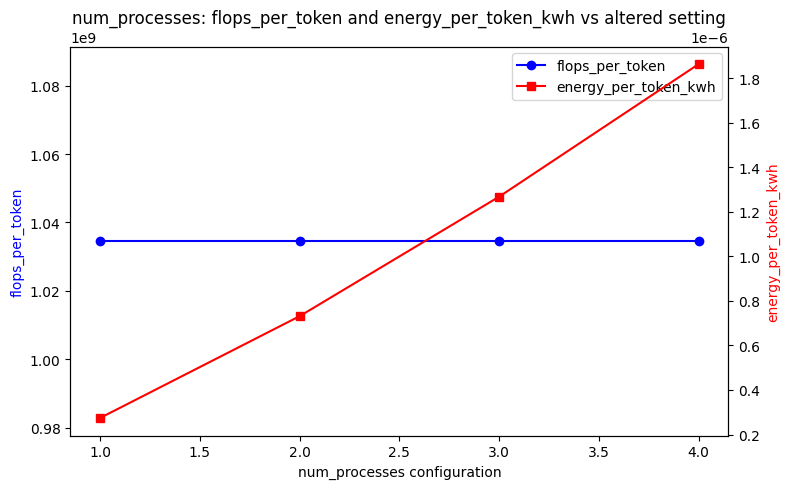

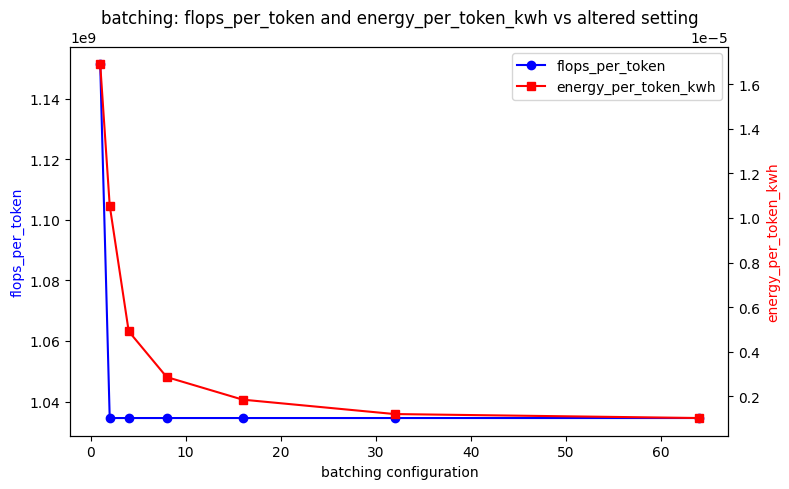

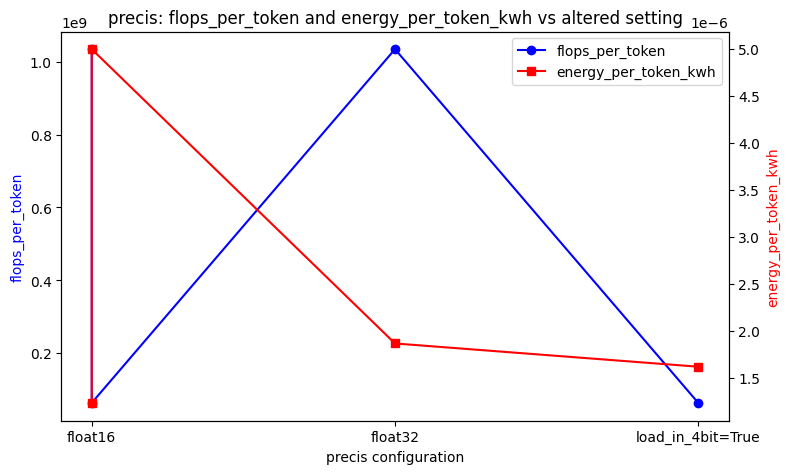

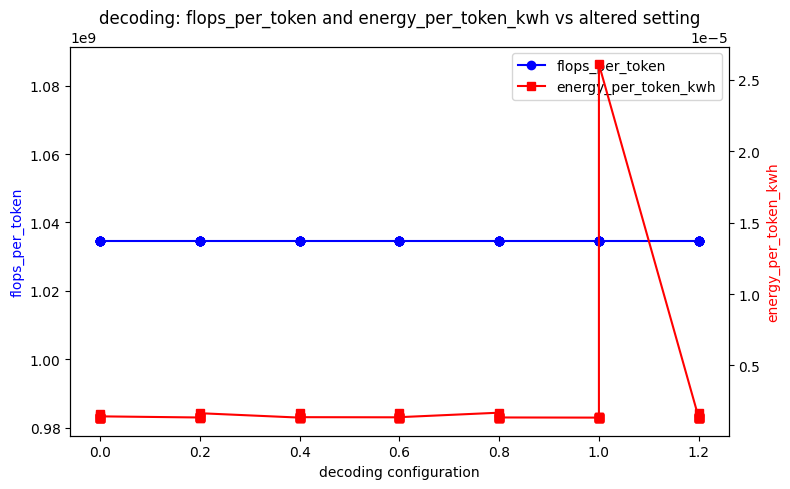

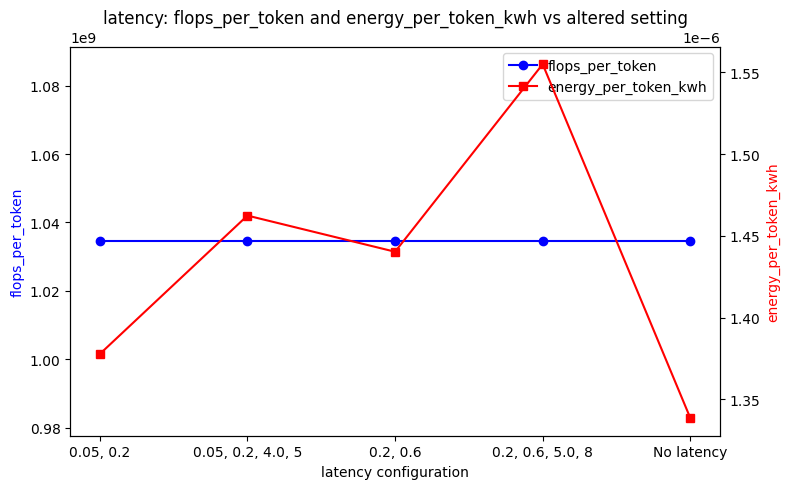

In [15]:
#cut this

def extract_altered_value(config_name, family):
    """
    Given a config name and a family, extract the altered value.
    For each family, a different rule is applied:
    
    - num_processes: extract the integer after "num_processes_"
    - batching: extract the integer after "batching_"
    - precis: extract the precision setting; if quant4 is True, return "load_in_4bit=True",
              otherwise return the float precision (e.g., "float32" or "float16")
    - decoding: extract the decoder_temperature (as a float) from the config name.
    - latency: if the config is exactly "latency_False", return "No latency"; otherwise, 
               extract and join all numeric values in the config string.
    """
    if family == "num_processes":
        m = re.search(r'num_processes_(\d+)', config_name)
        return int(m.group(1)) if m else config_name
    
    elif family == "batching":
        m = re.search(r'batching_(\d+)', config_name)
        return int(m.group(1)) if m else config_name
    
    elif family == "precis":
        m = re.search(r'precis_(float\d+)', config_name)
        precision = m.group(1) if m else None
        # If quant4 is True, we assume load_in_4bit is the relevant setting. COME BACK TO THIS!!!
        if "quant4_True" in config_name:
            return "load_in_4bit=True"
        else:
            return precision
        
    elif family == "decoding":
        # This family might have several variants. We extract the decoder_temperature. COME BACK TO
        m = re.search(r'decoder_temperature_([\d\.]+)', config_name)
        return float(m.group(1)) if m else config_name
    
    elif family == "latency":
        # If it's simply "latency_False", nothing was altered.
        if config_name == "latency_False":
            return "No latency"
        else:
            # Find all numbers (either integer or float) in the string.
            numbers = re.findall(r'\d+\.\d+|\d+', config_name)
            return ", ".join(numbers)
    else:
        return config_name

def plot_family(df, family, metric1, metric2):
    """
    For a given family, subset the DataFrame (rows whose config_name starts with family).
    Create a new column that holds the altered value for that family, sort the data by that value,
    and plot two metrics against this altered value.
    
    Parameters:
      - df: a DataFrame with a "config_name" column.
      - family: the family string (e.g. "num_processes", "batching", etc).
      - metric1: name of the first metric column to plot on the left Y axis (e.g., "flops_per_token").
      - metric2: name of the second metric column to plot on the right Y axis (e.g., "total_energy_kwh").
    """
    # Subset rows where config_name starts with the family string.
    df_family = df[df['config_name'].str.startswith(family)].copy()
    
    # Apply the parser to create an "altered_value" column.
    df_family['altered_value'] = df_family['config_name'].apply(lambda x: extract_altered_value(x, family))
    
    # Attempt to sort by altered_value.
    # If the values are numeric, convert them.
    try:
        df_family['altered_value'] = pd.to_numeric(df_family['altered_value'])
    except:
        pass  # leave as string if conversion fails
    
    df_family.sort_values('altered_value', inplace=True)
    
    # Create a plot with twin y-axes.
    fig, ax1 = plt.subplots(figsize=(8,5))
    ax2 = ax1.twinx()
    
    # Plot metric1 on ax1 and metric2 on ax2.
    ax1.plot(df_family['altered_value'], df_family[metric1], marker='o', label=metric1, color='blue')
    ax2.plot(df_family['altered_value'], df_family[metric2], marker='s', label=metric2, color='red')
    
    ax1.set_xlabel(f'{family} configuration')
    ax1.set_ylabel(metric1, color='blue')
    ax2.set_ylabel(metric2, color='red')
    plt.title(f'{family}: {metric1} and {metric2} vs altered setting')
    
    # Combine the legends.
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='best')
    
    plt.tight_layout()
    plt.show()


families = ["num_processes", "batching", "precis", "decoding", "latency"]

for fam in families:
    plot_family(df_controlled_dropped, fam, metric1="flops_per_token", metric2="energy_per_token_kwh")


--- 
# RESTART FROM HERE

## FOR CONTROLLED EXPERIMENTS

In [16]:
if file == possible_files[controlled]:
    
    df = df_controlled_dropped
    
    configs = ['num_processes', 'decoder', 'latency', 'batching', 'precis']
    dfs = {config: df[df['config_name'].str.startswith(config)] for config in configs}

NameError: name 'controlled' is not defined

In [ ]:
if file == possible_files[controlled]:
    
for name, df in dfs:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # ----- First subplot: Divergence Energy vs Batch Size -----
    axes[0].plot(
        df['num_processes'],
        df['divergence_energy_flops_per_token'],
        marker='o', 
        linestyle='-',
        color='orange'
    )
    axes[0].set_xlabel('Batch Size (Fixed Batching)')
    axes[0].set_ylabel('Divergence Energy ~FLOPs per Token')
    axes[0].set_title(f'Divergence Energy vs Batch Size ({name})')
    axes[0].set_xticks(df['num_processes'])
    axes[0].grid(True)

    # ----- Second subplot: Two Y-axes with Energy per Token and FLOPs per Token -----
    ax1 = axes[1]
    line1, = ax1.plot(
        df['num_processes'], 
        df['energy_per_token_kwh'], 
        marker='o', 
        linestyle='-', 
        color='blue', 
        label='Energy per Token (kWh)'
    )
    ax1.set_xlabel('Batch Size (Fixed Batching)')
    ax1.set_ylabel('Energy per Token (kWh)', color='blue')
    ax1.tick_params(axis='y')
    ax1.set_xticks(df['num_processes'])
    ax1.set_title(f'Metrics vs Batch Size ({name})')
    ax1.grid(True)

    ax2 = ax1.twinx()
    line2, = ax2.plot(
        df['num_processes'], 
        df['flops_per_token'], 
        marker='s', 
        linestyle='--', 
        color='red', 
        label='FLOPs per Token'
    )
    ax2.set_ylabel('FLOPs per Token', color='red')
    ax2.tick_params(axis='y')

    # Combine legends
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc='best')

    plt.tight_layout()
    plt.show()


In [ ]:
    import matplotlib.pyplot as plt

    # Step 1: Create a new 'precision' column for plotting
    def determine_precision(row):
        if row.get('load_in_4bit', False):
            return 'INT4'
        elif row.get('load_in_8bit', False):
            return 'INT8'
        elif row.get('fp_precision') == 'torch.float16':
            return 'FP16'
        else:
            return 'FP32'

    precics_df['precision'] = precics_df.apply(determine_precision, axis=1)

    # Step 2: Define custom precision order
    precision_order = ['FP32', 'FP16', 'INT8', 'INT4']

    # Step 3: Sort the dataframe according to precision order
    precics_df['precision'] = pd.Categorical(precics_df['precision'], categories=precision_order, ordered=True)
    precics_df = precics_df.sort_values('precision')

    # Step 4: Plotting
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # ----- First subplot: Divergence Energy vs Precision -----
    axes[0].plot(
        precics_df['precision'],
        precics_df['divergence_energy_flops_per_token'],
        marker='o', 
        linestyle='-',
        color='orange'
    )
    axes[0].set_xlabel('Precision')
    axes[0].set_ylabel('Divergence Energy ~FLOPs per Token')
    axes[0].set_title('Divergence Energy vs Precision')
    axes[0].grid(True)

    # ----- Second subplot: Two Y-axes with Energy per Token and FLOPs per Token -----
    ax1 = axes[1]
    line1, = ax1.plot(
        precics_df['precision'], 
        precics_df['energy_per_token_kwh'], 
        marker='o', 
        linestyle='-', 
        color='blue', 
        label='Energy per Token (kWh)'
    )
    ax1.set_xlabel('Precision')
    ax1.set_ylabel('Energy per Token (kWh)', color='blue')
    ax1.tick_params(axis='y')
    ax1.set_title('Metrics vs Precision')
    ax1.grid(True)

    ax2 = ax1.twinx()
    line2, = ax2.plot(
        precics_df['precision'], 
        precics_df['flops_per_token'], 
        marker='s', 
        linestyle='--', 
        color='red', 
        label='FLOPs per Token'
    )
    ax2.set_ylabel('FLOPs per Token', color='red')
    ax2.tick_params(axis='y')

    # Combine legends
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc='best')

    plt.tight_layout()
    plt.show()

In [ ]:
if file == possible_files[controlled]:

    # --- Step 1: Filter the dataframe based on the config names ---
    config_names = [
        'decoding_greedy_decoder_temperature_0',
        'decoding_greedy_decoder_temperature_0.7',
        'decoding_greedy_decoder_temperature_1.0',
        'decoding_greedy_decoder_temperature_1.3',
        'decoding_top_k_decoder_top_k_50_decoder_temperature_0',
        'decoding_top_k_decoder_top_k_50_decoder_temperature_0.7',
        'decoding_top_k_decoder_top_k_50_decoder_temperature_1.0',
        'decoding_top_k_decoder_top_k_50_decoder_temperature_1.3',
        'decoding_top_p_decoder_top_p_0.9_decoder_temperature_0',
        'decoding_top_p_decoder_top_p_0.9_decoder_temperature_0.7',
        'decoding_top_p_decoder_top_p_0.9_decoder_temperature_1.0',
        'decoding_top_p_decoder_top_p_0.9_decoder_temperature_1.3'
    ]
    filtered_decoding = decoding_df[decoding_df['config_name'].isin(config_names)].copy()

    # --- Step 2: Extract method and temperature from the config_name ---
    def extract_method_and_temp(config):
        if config.startswith("decoding_greedy_decoder_temperature_"):
            temp = float(config.split("decoding_greedy_decoder_temperature_")[-1])
            return "greedy", temp
        elif config.startswith("decoding_top_k_decoder_top_k_50_decoder_temperature_"):
            temp = float(config.split("decoding_top_k_decoder_top_k_50_decoder_temperature_")[-1])
            return "top_k", temp
        elif config.startswith("decoding_top_p_decoder_top_p_0.9_decoder_temperature_"):
            temp = float(config.split("decoding_top_p_decoder_top_p_0.9_decoder_temperature_")[-1])
            return "top_p", temp
        else:
            return "unknown", None

    # Apply the extraction function and assign to new columns
    filtered_decoding[['method', 'temperature']] = filtered_decoding['config_name'].apply(
        lambda x: pd.Series(extract_method_and_temp(x))
    )

    # Optionally sort the dataframe by method and temperature for clarity.
    filtered_decoding = filtered_decoding.sort_values(['method', 'temperature'])

    # --- Step 3: Plotting ---

    # Define colors for each method
    colors = {
        'greedy': 'blue',
        'top_k': 'green',
        'top_p': 'red'
    }

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # --- Left subplot: Divergence Energy vs Temperature ---
    ax_left = axes[0]
    methods = filtered_decoding['method'].unique()
    for m in methods:
        subdf = filtered_decoding[filtered_decoding['method'] == m]
        ax_left.plot(subdf['temperature'], subdf['divergence_energy_flops_per_token'],
                    marker='o', linestyle='-', label=m, color=colors.get(m))
    ax_left.set_xlabel('Decoder Temperature')
    ax_left.set_ylabel('Divergence Energy ~FLOPs per Token')
    ax_left.set_title('Divergence Energy vs Decoder Temperature')
    ax_left.grid(True)
    ax_left.legend(title="Method")

    # --- Right subplot: Two Y-axes with Energy per Token and FLOPs per Token ---
    ax1 = axes[1]
    # Primary axis for Energy per Token
    for m in methods:
        subdf = filtered_decoding[filtered_decoding['method'] == m]
        ax1.plot(subdf['temperature'], subdf['energy_per_token_kwh'],
                marker='o', linestyle='-', label=f'{m} Energy', color=colors.get(m))
    ax1.set_xlabel('Decoder Temperature')
    ax1.set_ylabel('Energy per Token (kWh)', color='black')
    ax1.set_title('Metrics vs Decoder Temperature')
    ax1.grid(True)

    # Secondary axis for FLOPs per Token
    ax2 = ax1.twinx()
    for m in methods:
        subdf = filtered_decoding[filtered_decoding['method'] == m]
        ax2.plot(subdf['temperature'], subdf['flops_per_token'],
                marker='s', linestyle='--', label=f'{m} FLOPs', color=colors.get(m))
    ax2.set_ylabel('FLOPs per Token', color='black')

    # --- Combine legends from both axes ---
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

    plt.tight_layout()
    plt.show()


In [ ]:
if file == possible_files[controlled]:

    # --- 1. Filter the latency_df to only keep the specified configurations ---
    latency_configs = [
        'latency_False',
        'latency_True_latency_0.05_latency_0.2_latency_False',
        'latency_True_latency_0.2_latency_0.6_latency_False',
        'latency_True_latency_0.05_latency_0.2_latency_True_latency_4.0_latency_5',
        'latency_True_latency_0.2_latency_0.6_latency_True_latency_5.0_latency_8'
    ]
    latency_filtered = latency_df[latency_df['config_name'].isin(latency_configs)].copy()

    # --- 2. Define a function to parse the config string ---
    def parse_latency_config(config):
        """
        Parses a latency configuration string and returns a dict with:
        - simulate (boolean)
        - delay_min (float or None)
        - delay_max (float or None)
        - simulate_burst (boolean or None)
        - burst_size (float or None)
        - burst_interval (float or None)
        """
        tokens = config.split('_')
        
        # There will be extra "latency" tokens in the string.
        # Look at the total number of tokens:
        # For baseline: e.g., "latency_False" -> tokens: ["latency", "False"]
        # Without burst: 8 tokens, e.g.:
        #   ["latency", "True", "latency", "0.05", "latency", "0.2", "latency", "False"]
        # With burst: 12 tokens, e.g.:
        #   ["latency", "True", "latency", "0.05", "latency", "0.2", "latency", "True", "latency", "4.0", "latency", "5"]
        res = {}
        if len(tokens) == 2:
            # Baseline: no simulation
            res['simulate'] = (tokens[1] == "True")
            res['delay_min'] = None
            res['delay_max'] = None
            res['simulate_burst'] = None
            res['burst_size'] = None
            res['burst_interval'] = None
        elif len(tokens) == 8:
            # Without burst: tokens at positions 1, 3, 5, and 7 are our values.
            res['simulate'] = (tokens[1] == "True")
            res['delay_min'] = float(tokens[3])
            res['delay_max'] = float(tokens[5])
            res['simulate_burst'] = (tokens[7] == "True")
            res['burst_size'] = None
            res['burst_interval'] = None
        elif len(tokens) == 12:
            # With burst: tokens at positions 1, 3, 5, 7, 9, and 11.
            res['simulate'] = (tokens[1] == "True")
            res['delay_min'] = float(tokens[3])
            res['delay_max'] = float(tokens[5])
            res['simulate_burst'] = (tokens[7] == "True")
            res['burst_size'] = float(tokens[9])
            res['burst_interval'] = float(tokens[11])
        else:
            res['simulate'] = None
            res['delay_min'] = None
            res['delay_max'] = None
            res['simulate_burst'] = None
            res['burst_size'] = None
            res['burst_interval'] = None
        return res

    # Apply the parser so that we have new columns for the latency parameters
    latency_params = latency_filtered['config_name'].apply(lambda x: pd.Series(parse_latency_config(x)))
    latency_filtered = pd.concat([latency_filtered, latency_params], axis=1)

    # --- 3. Create a user-friendly label for each configuration ---
    def make_latency_label(row):
        if row['simulate'] is False:
            return "No simulation"
        elif row['simulate'] is True and row['simulate_burst'] is False:
            return f"Sim ({row['delay_min']}-{row['delay_max']})"
        elif row['simulate'] is True and row['simulate_burst'] is True:
            return f"Sim ({row['delay_min']}-{row['delay_max']}) Burst ({row['burst_size']},{row['burst_interval']})"
        else:
            return "Unknown"

    latency_filtered['latency_label'] = latency_filtered.apply(make_latency_label, axis=1)

    # --- 4. Order the configurations as desired ---
    order_labels = [
        "No simulation",
        "Sim (0.05-0.2)",
        "Sim (0.2-0.6)",
        "Sim (0.05-0.2) Burst (4.0,5)",
        "Sim (0.2-0.6) Burst (5.0,8)"
    ]
    latency_filtered['latency_label'] = pd.Categorical(latency_filtered['latency_label'], 
                                                        categories=order_labels, ordered=True)
    latency_filtered = latency_filtered.sort_values('latency_label')

    # --- 5. Create the two subplots ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Left Subplot: Divergence Energy vs Latency Configuration (categorical x-axis)
    axes[0].plot(
        latency_filtered['latency_label'],
        latency_filtered['divergence_energy_flops_per_token'],
        marker='o',
        linestyle='-',
        color='orange'
    )
    axes[0].set_xlabel('Latency Configuration')
    axes[0].set_ylabel('Divergence Energy ~FLOPs per Token')
    axes[0].set_title('Divergence Energy vs Latency Config')
    axes[0].grid(True)

    # Right Subplot: Two y-axes for Energy per Token and FLOPs per Token
    ax1 = axes[1]
    line1, = ax1.plot(
        latency_filtered['latency_label'],
        latency_filtered['energy_per_token_kwh'],
        marker='o',
        linestyle='-',
        color='blue',
        label='Energy per Token (kWh)'
    )
    ax1.set_xlabel('Latency Configuration')
    ax1.set_ylabel('Energy per Token (kWh)', color='blue')
    ax1.tick_params(axis='y')
    ax1.set_title('Metrics vs Latency Config')
    ax1.grid(True)

    # Create secondary y-axis for FLOPs per Token
    ax2 = ax1.twinx()
    line2, = ax2.plot(
        latency_filtered['latency_label'],
        latency_filtered['flops_per_token'],
        marker='s',
        linestyle='--',
        color='red',
        label='FLOPs per Token'
    )
    ax2.set_ylabel('FLOPs per Token', color='red')
    ax2.tick_params(axis='y')

    # Combine legends from both axes
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc='best')

    plt.tight_layout()
    plt.show()


In [ ]:
if file == possible_files[controlled]:
    print(f"var energy: {df_controlled_dropped.total_energy_kwh.max()} / {df_controlled_dropped.total_energy_kwh.min()})

WORK OUT STANDARD DEVIATIONS

In [ ]:


# Histogram of raw total_energy_kwh
plt.figure(figsize=(10, 6))
plt.hist(df_scenarios_dropped['total_energy_kwh'], bins=50, edgecolor='black')
plt.title('Distribution of Total Energy (kWh)')
plt.xlabel('Total Energy (kWh)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Boxplot to spot outliers
plt.figure(figsize=(10, 2))
plt.boxplot(df_scenarios_dropped['total_energy_kwh'], vert=False)
plt.title('Boxplot of Total Energy (kWh)')
plt.xlabel('Total Energy (kWh)')
plt.grid(True)
plt.show()

# If distribution is very skewed: log-transform
plt.figure(figsize=(10, 6))
plt.hist(np.log(df_scenarios_dropped['total_energy_kwh']), bins=50, edgecolor='black')
plt.title('Distribution of Log-Transformed Total Energy (kWh)')
plt.xlabel('Log(Total Energy (kWh))')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


# for Scenario Experiments

In [ ]:
if file == possible_files["scenario"]


In [ ]:
df_scenarios_dropped.total_energy_kwh.max() / df_scenarios_dropped.total_energy_kwh.min()